In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Load the dataset

df = pd.read_csv('hotel_bookings.csv')

In [26]:
# Columns with missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_report = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
}).sort_values(by='Percentage', ascending=False)

print("Missing Value Report:")
display(missing_report)

Missing Value Report:


,Missing Values,Percentage
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
hotel,0,0.000000
is_canceled,0,0.000000
stays_in_weekend_nights,0,0.000000
arrival_date_day_of_month,0,0.000000


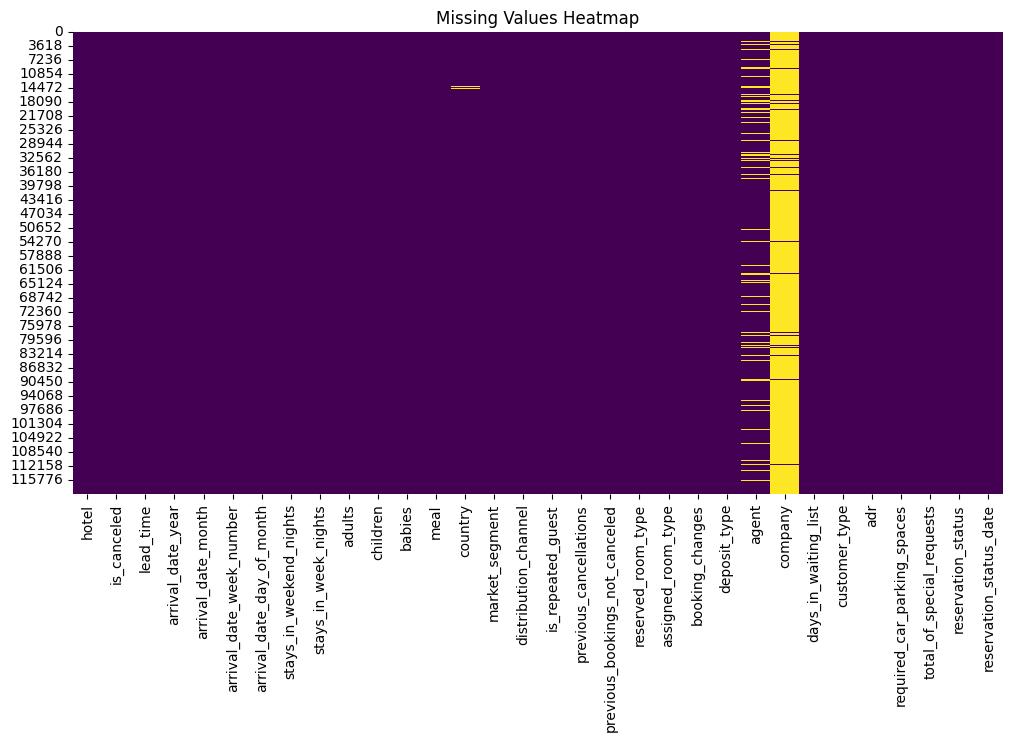

In [27]:
# Heatmap to visualize missing data
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [28]:
# Duplicate records
duplicate_count = df.duplicated().sum()
print(f"Duplicate records: {duplicate_count}")


Duplicate records: 31994


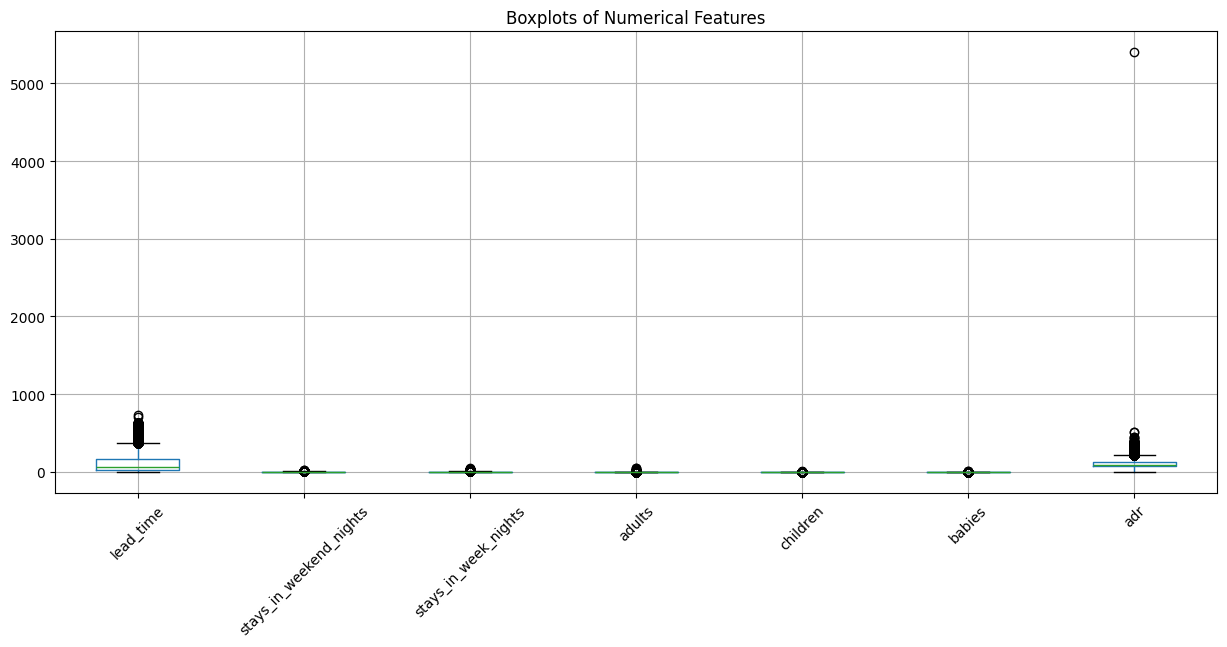

hotel unique values:
hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64

arrival_date_month unique values:
arrival_date_month
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: count, dtype: int64

meal unique values:
meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64

country unique values:
country
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
MRT        1
KIR        1
SDN        1
ATF        1
SLE        1
Name: count, Length: 178, dtype: int64

market_segment unique values:
market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name

In [29]:
# Outliers: quick boxplot view
num_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'adr']
df[num_cols].boxplot(figsize=(15, 6))
plt.title("Boxplots of Numerical Features")
plt.xticks(rotation=45)
plt.show()

# Check for categorical inconsistencies
for col in df.select_dtypes(include='object').columns:
    print(f"{col} unique values:\n{df[col].value_counts(dropna=False)}\n")

In [30]:
# 1. Children: Replace NaN with 0
df['children'].fillna(0, inplace=True)

# 2. Country: Fill with mode or 'Unknown'
df['country'].fillna(df['country'].mode()[0], inplace=True)  # or 'Unknown'

# 3. Agent: Replace NaN with 0 and convert to int
df['agent'].fillna(0, inplace=True)
df['agent'] = df['agent'].astype(int)

# 4. Company: Replace NaN with 0 and convert to int
df['company'].fillna(0, inplace=True)
df['company'] = df['company'].astype(int)

In [31]:
# Exact duplicates
duplicates = df[df.duplicated()]
print(f"Exact Duplicates Found: {len(duplicates)}")

# Drop exact duplicates
df.drop_duplicates(inplace=True)

Exact Duplicates Found: 32013


In [32]:
# IQR Method for ADR
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outliers
outliers = df[(df['adr'] < lower_bound) | (df['adr'] > upper_bound)]
print(f"Outliers in 'adr': {outliers.shape[0]}")

# Option 1: Cap values
df['adr'] = np.where(df['adr'] > upper_bound, upper_bound, df['adr'])

# Option 2: Remove (alternative approach)
# df = df[(df['adr'] >= lower_bound) & (df['adr'] <= upper_bound)]

Outliers in 'adr': 2488


In [33]:
# 1. Create full arrival date from components
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' +
                                    df['arrival_date_month'] + '-' +
                                    df['arrival_date_day_of_month'].astype(str), errors='coerce')

# 2. Fix impossible rows (guests = 0)
df = df[~((df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0))]

# 3. Standardize country codes if needed
df['country'] = df['country'].str.upper()


In [34]:
# Guests > 0
assert (df['adults'] + df['children'] + df['babies'] > 0).all(), "Some bookings have zero guests!"

# Arrival date range
print(df['arrival_date'].min(), df['arrival_date'].max())

# Reasonable range for adr
print(f"ADR range: {df['adr'].min()} to {df['adr'].max()}")


2015-07-01 00:00:00 2017-08-31 00:00:00
ADR range: -6.38 to 227.0


In [35]:
df.to_csv('hotel_bookings_cleaned.csv', index=False)

In [36]:
from google.colab import files
files.download('hotel_bookings_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>